In [1]:
"""
## Introduction
ESPCN (Efficient Sub-Pixel CNN), proposed by [Shi, 2016](https://arxiv.org/abs/1609.05158)
is a model that reconstructs a high-resolution version of an image given a low-resolution version.
It leverages efficient "sub-pixel convolution" layers, which learns an array of
image upscaling filters.
In this code example, we will implement the model from the paper and train it on a small dataset,
[BSDS500](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html).
"""

"""
## Setup
"""

import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm


In [2]:
# Check GPU Avalability
from tensorflow.python.client import device_lib
import torch

print(f"Torch GPU: {torch.cuda.is_available()}")

print(device_lib.list_local_devices())

Torch GPU: True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11475741542268967762
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10087235584
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13599052726803467404
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:26:00.0, compute capability: 8.6"
]


In [3]:
import numpy as np
SEED = 31
np.random.seed(SEED)

# Data

In [4]:
#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir("images/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("images/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr/255.)   


hr_list = os.listdir("images/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("images/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr/255.)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

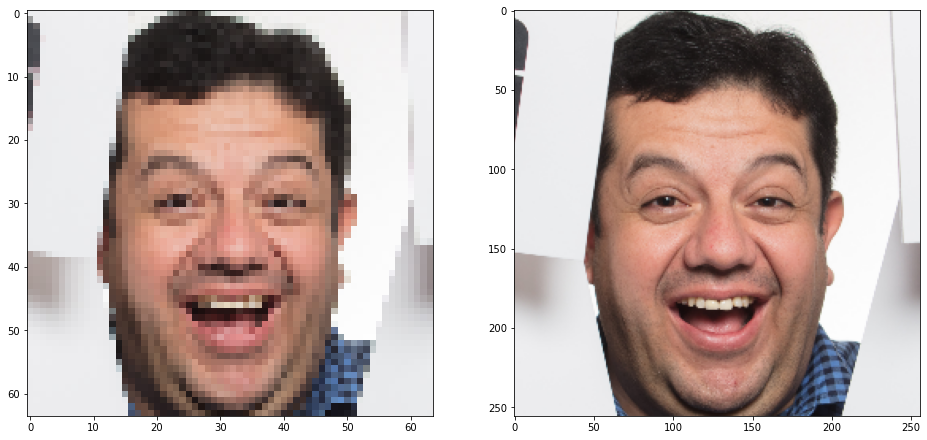

In [5]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_list)-1)
plt.figure(figsize=(16, 16))
plt.subplot(121)
img_lr = cv2.imread("images/lr_images/" + lr_list[image_number])
img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
plt.imshow(img_lr)

plt.subplot(122)
img_hr = cv2.imread("images/hr_images/" + hr_list[image_number])
img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
plt.imshow(img_hr)
plt.show()

In [6]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.20, random_state=42)


In [7]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [8]:
#Generator model
def create_gen(channels, num_res_block):
    gen_ip = keras.Input(shape=(64, 64, channels))
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [9]:

"""
Define `ModelCheckpoint` and `EarlyStopping` callbacks.
"""

early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = create_gen(channels=3, num_res_block = 16)
model.summary()

callbacks = [early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.00001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 64, 64, 64)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       p_re_lu[0][0]                    
______________________________________________________________________________________________

In [10]:

epochs = 200

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
)

model.fit(
    lr_train, hr_train, epochs=epochs, callbacks=callbacks, verbose=2, batch_size=8, validation_data=(lr_test, hr_test)
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/200
500/500 - 232s - loss: 0.0271 - val_loss: 0.0110
Epoch 2/200
500/500 - 221s - loss: 0.0105 - val_loss: 0.0076
Epoch 3/200
500/500 - 215s - loss: 0.0076 - val_loss: 0.0063
Epoch 4/200
500/500 - 219s - loss: 0.0064 - val_loss: 0.0055
Epoch 5/200
500/500 - 220s - loss: 0.0056 - val_loss: 0.0049
Epoch 6/200
500/500 - 222s - loss: 0.0051 - val_loss: 0.0045
Epoch 7/200
500/500 - 216s - loss: 0.0047 - val_loss: 0.0043
Epoch 8/200
500/500 - 217s - loss: 0.0044 - val_loss: 0.0040
Epoch 9/200
500/500 - 218s - loss: 0.0041 - val_loss: 0.0037
Epoch 10/200
500/500 - 218s - loss: 0.0039 - val_loss: 0.0036
Epoch 11/200
500/500 - 217s - loss: 0.0038 - val_loss: 0.0035
Epoch 12/200
500/500 - 215s - loss: 0.0036 - val_loss: 0.0033
Epoch 13/200
500/500 - 224s - loss: 0.0035 - val_loss: 0.0032
Epoch 14/200
500/500 - 214s - loss: 0.0033 - val_loss: 0.0033
Epoch 15/200
500/500 - 216s - loss: 0.0033 - val_loss: 0.0030
Epoch 16/200
500/500 - 218s - loss: 0.0032 - val_loss: 0.0030
Epoch 17/200
500/

Epoch 133/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 134/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 135/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 136/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 137/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 138/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 139/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 140/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 141/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 142/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 143/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 144/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 145/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 146/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 147/200
500/500 - 212s - loss: 0.0020 - val_loss: 0.0020
Epoch 148/200
500/500 - 212s - loss: 0.0020 - val_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


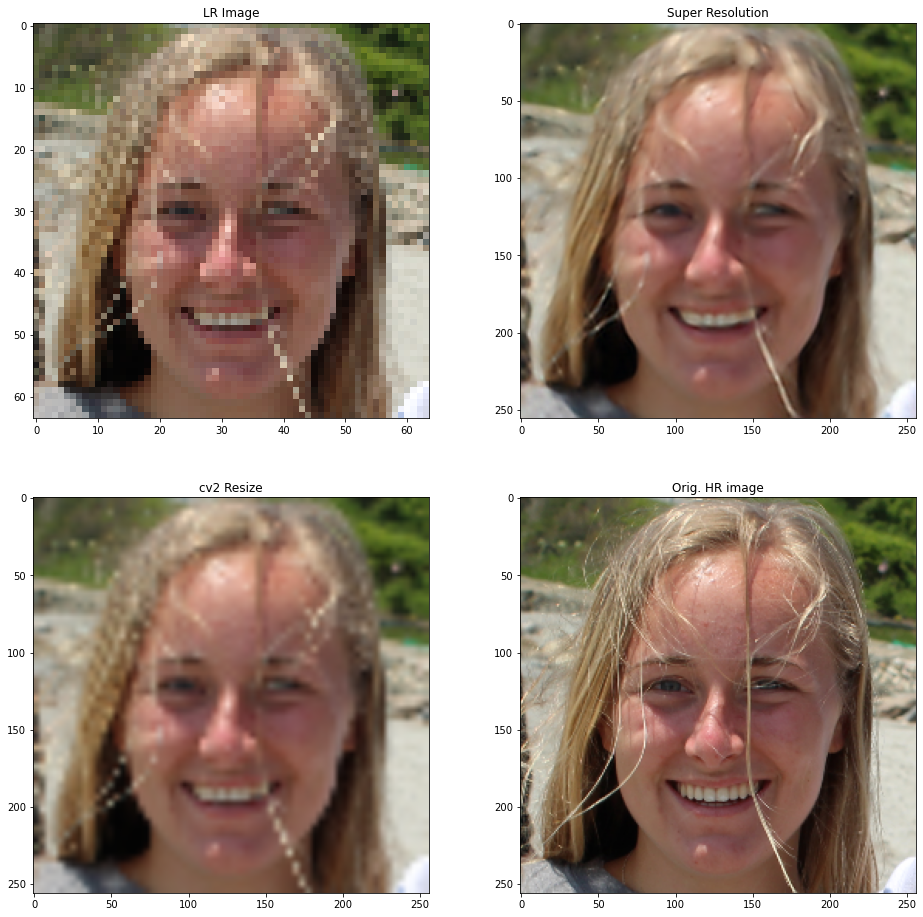

In [22]:
from keras.models import load_model
from numpy.random import randint

[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = model.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(222)
plt.title('Super Resolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(223)
plt.title('cv2 Resize')
plt.imshow(
    cv2.resize(src_image[0,:,:,:], (256,256))
)
plt.subplot(224)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()